In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.signal import stft
import librosa
import cv2
import pywt
import matplotlib.pyplot as plt

import jax
from tqdm import tqdm
import jax.numpy as jnp
import matplotlib.pyplot as plt
from superlets import wavelet_transform, adaptive_superlet_transform

In [3]:
devices = jax.devices("gpu")
gpu_device = devices[0]


In [4]:
devices

[gpu(id=0)]

In [252]:
class CustomDataset(Dataset):
    def __init__(self, csv_path, transform=None, USE_WAVELET='db16',root = '..',specMethod = 'mel'):
        '''
        csv_path: path to your metadata
        \n
        USE_WAVELET:
        \n
        \t'LPF10'-> for low pass with 10 Hz \n
        \t'LPF20'-> for low pass with 20 Hz \n
        \t'USE_WAVELET'-> use other default wavelets \n
        root: path to 'hms-harmful-brain-activity-classification'
        specMethod: 'mel', 'SL','CWT'
        '''

        self.metadata = pd.read_csv(csv_path)
        self.transform = transform

        self.USE_WAVELET = USE_WAVELET

        self.root = root
        self.specMethod = specMethod

        self.NAMES = ['LL','LP','RP','RR']

        self.FEATS = [['Fp1','F7','T3','T5','O1'],
                ['Fp1','F3','C3','P3','O1'],
                ['Fp2','F8','T4','T6','O2'],
                ['Fp2','F4','C4','P4','O2']]

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        
        retSpecs,consensus, labels, offset, eeg_id = self.spectrogram_from_eeg(idx)

        if self.transform:
            retSpecs = self.transform(retSpecs)

        return retSpecs, labels, offset, eeg_id
    
    def spectrogram_from_eeg(self,eeg_id, display=False):
    

        sliced_eegs,consensus, labels, offset, eeg_id = self.getWindowsfromEEG(eeg_id)
        eeg = sliced_eegs[0]
        
        
        if display: plt.figure(figsize=(10,7))

        retSpecs = []
        retEEGs = []
        ogEEGs = []

        img = np.zeros((128,128),dtype='float32')
        signals = []
        signalsX = []
        signalsXOG = []
        for k in range(4):
            COLS = self.FEATS[k]

            tempSpec= np.zeros((128,128))

            if self.USE_WAVELET=="LPF10" or self.USE_WAVELET=="LPF20" or self.USE_WAVELET == "None":
                temp = np.zeros((2001))
                tempOG = np.zeros((2001))
            else:
                temp = np.zeros((2002))
                tempOG = np.zeros((2001))
            
            for kk in range(4):
            
        
                x = eeg[COLS[kk]] - eeg[COLS[kk+1]]
                tempOG+=x
        
                m = np.nanmean(x)
                if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
                else: x[:] = 0

                
                if self.USE_WAVELET=='LPF10':
            
                    x = self.apply_lpf(x,cutoff_freq=10)
                elif self.USE_WAVELET=='LPF20':
            
                    x = self.apply_lpf(x,cutoff_freq=20)
                else:
                    x = self.denoise(x, wavelet=self.USE_WAVELET)

                temp+=x
                signals.append(x)
                

                # MEL SPEC, STFT, CWT and Superlets

                if self.specMethod == 'MEL':

                    mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//128, 
                        n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

            
                    width = (mel_spec.shape[1]//32)*32
                    
                    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

            
                    mel_spec_db = (mel_spec_db+40)/40 

                    tempSpec += mel_spec_db

                if self.specMethod == 'SL':
                    
                    # print('OK')
                    
                    freqs = jnp.linspace(0.5, 40, 100)

                    x = jnp.array(x)

                    scalogram = adaptive_superlet_transform(x, freqs, sampling_freq=200, 
                                            base_cycle=1, min_order=1, 
                                            max_order=16, mode="add")
                    
                    image = np.abs(scalogram)**2
                    image_normalized = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
                    image_to_show = np.uint8(image_normalized)

                    
                    # image_colored = cv2.applyColorMap(image_to_show, cv2.COLORMAP_JET)

                    # window_name = f"Base cycles: {base_cycle}, Orders: {min_order}-{max_order}"
                    # cv2.imwrite(f'superlet-{i}.png',image_to_show)
                    tempSpec += cv2.resize(image_to_show, (128, 128))



                if self.specMethod == 'CWT':

                    def spectrogram_cwt(signal, wavelet='morl', scales=np.arange(1, 128)):
                        coeffs, freqs = pywt.cwt(signal, scales, wavelet)
                        power = (np.abs(coeffs)) ** 2
                        return power, freqs


                    fs = 200
                    t = np.arange(0, 10, 1/fs)
                    

                    scales = np.arange(1, 32)


                    power, freqs = spectrogram_cwt(x, scales=scales)


                    power_normalized = ((power - power.min()) / (power.max() - power.min()) * 255).astype(np.uint8)



                    spectrogram_image_resized = cv2.resize(power_normalized, (128, 128))

                    tempSpec += spectrogram_image_resized

                
            temp/=4.0
            tempOG/=4.0
            
            signalsX.append(temp)    
            signalsXOG.append(tempOG)


            tempSpec /= 4.0

            img  = np.vstack((img,tempSpec))


        retSpecs.append(img[128:])

        retEEGs.append(np.array(signalsX))
        ogEEGs.append(np.array(signalsXOG))


        return np.array(retSpecs[0]), consensus, labels, offset, eeg_id

    def getWindowsfromEEG(self,loc):

        labelMap = {'Seizure':0,'GPD':1,'LRDA':2,'Other':3,'GRDA':4,'LPD':5}

        subSet = self.metadata.iloc[loc]
        eeg_id = subSet['eeg_id']

        labels = np.array([int(subSet['seizure_vote']), int(subSet['lpd_vote']) , int(subSet['gpd_vote'])
                        ,int(subSet['lrda_vote']), int(subSet['grda_vote']), int(subSet['other_vote'])])

        consensus = labelMap[subSet['expert_consensus']]

        eeg = pd.read_parquet(f'{self.root}/train_eegs/{eeg_id}.parquet')

        fs = 200
        eeg["time"] = eeg.index / fs
        eeg.set_index("time", inplace=True)
        eeg.index

        offSet = int(subSet['eeg_label_offset_seconds'])

        toRet = []

        toRet.append(eeg.loc[offSet+20:offSet+30])

        return toRet,np.array(consensus), np.array(labels),np.array(offSet),np.array(eeg_id)

    def apply_lpf(self,data, sampling_rate=200, cutoff_freq=10, order=5):

        nyquist_freq = 0.5 * sampling_rate
        normal_cutoff = cutoff_freq / nyquist_freq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        filtered_data = filtfilt(b, a, data)

        return filtered_data

    def maddest(self,d, axis=None):
        return np.mean(np.absolute(d - np.mean(d, axis)), axis)

    def denoise(self,x, wavelet='haar', level=1):    
        coeff = pywt.wavedec(x, wavelet, mode="per")
        sigma = (1/0.6745) * self.maddest(coeff[-level])

        uthresh = sigma * np.sqrt(2*np.log(len(x)))
        coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

        ret=pywt.waverec(coeff, wavelet, mode='per')
        
        return ret
    

In [253]:
specMethods = ['MEL','CWT','SL']
filteringMethods = ['LPF10','LPF20','db8','haar']

In [254]:
i=2
j=2

In [255]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128))
])


batch_size = 1

train_path = 'hms-harmful-brain-activity-classification/train_mine.csv'
test_path = 'hms-harmful-brain-activity-classification/test_mine.csv'
val_path = 'hms-harmful-brain-activity-classification/val_mine.csv'
root = 'hms-harmful-brain-activity-classification'



train_dataset = CustomDataset(csv_path=train_path, transform=transform,root=root,USE_WAVELET=filteringMethods[i],specMethod=specMethods[j])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


test_dataset = CustomDataset(csv_path=test_path, transform=transform,root=root,USE_WAVELET=filteringMethods[i],specMethod=specMethods[j])
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


val_dataset = CustomDataset(csv_path=val_path, transform=transform,root=root,USE_WAVELET=filteringMethods[i],specMethod=specMethods[j])
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


In [256]:
newDataPath = f'hms-harmful-brain-activity-classification-{filteringMethods[i]}-{specMethods[j]}'

In [257]:
newDataPath

'hms-harmful-brain-activity-classification-db8-SL'

In [258]:
dataSubsets = ['train','test','val']
loaderDict = {'train':train_loader,'test':test_loader,'val':val_loader}

In [263]:
specs,labels, offset, eeg_id = next(iter(loaderDict[dataSubsets[2]]))

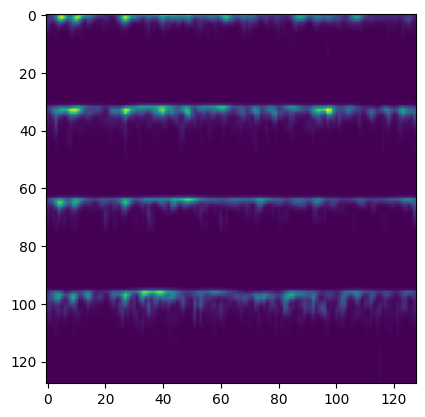

In [264]:
plt.imshow(specs.squeeze().cpu())

In [96]:
os.mkdir(newDataPath)

In [50]:
os.chdir(newDataPath)

In [51]:
os.mkdir('train')
os.mkdir('test')
os.mkdir('val')

In [52]:
os.chdir('../')

In [53]:
dataSubsets = ['train','test','val']
loaderDict = {'train':train_loader,'test':test_loader,'val':val_loader}
for i in dataSubsets:
    print(f'Saving Processed Specs for {i}...')
    print(len(loaderDict[i]))

    for specs,labels, offset, eeg_id in tqdm(iter(loaderDict[i])):

        img,label,offset,eeg_id = specs.squeeze(),labels.squeeze(), offset.squeeze(), eeg_id.squeeze()

        plt.imsave(f'{newDataPath}/{i}/{eeg_id}-{offset}.png',img.cpu().numpy())

    



Saving Processed Specs for train...
85440


  0%|          | 179/85440 [00:33<4:22:00,  5.42it/s]


KeyboardInterrupt: 